In [0]:
!mkdir checkpoint
CUDA_LAUNCH_BLOCKING=1
import os, time, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
#remember to upload data into your colab workspace
import os, time, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
import math
import pickle

# GPU support
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

#to first try out model, we start with 1600 training samples and 400 testing samples

def impute_missing_values(X):
    """
    For each feature column, impute missing values  (np.nan) with the 
    population mean for that feature.
    
    Args:
        X: np.array, shape (N, L, d). X could contain missing values
    Returns:
        X: np.array, shape (N, L, d). X does not contain any missing values
    """
    N, L, d = X.shape
    X = X.reshape(N*L, d)
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return X.reshape(N, L, d)
  
def standardize_features(X):
    """
    For each feature column, normalize all values to range [0, 1].
    Args:
        X: np.array, shape (N, d).
    Returns:
        X: np.array, shape (N, d). Values are normalized per column.
    """
    scaler = StandardScaler()
    N, L, d = X.shape
    X = X.reshape(N*L, d)
    X = scaler.fit_transform(X)
    return X.reshape(N, L, d)

using device: cpu


In [0]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
    def __len__(self):
        return len(self.X)

def get_train_val_test(batch_size=64):

    with open("features_labels_12000.p", 'rb') as f:
      features, df_labels = pickle.load(f)
      X = np.array([df_i.values for df_i in features])[0:10000,:,0:35]
      y = df_labels['In-hospital_death'].values.copy()[0:10000]
      y[y == -1] = 0
    
    #X=np.load("X.npy")
    #y=np.load("y.npy")
    np.save("X.npy",X)
    np.save("y.npy",y)
    X=impute_missing_values(X)
    X=standardize_features(X)
    #print(X[0,1,:])
    print(np.argwhere(np.isnan(X)),np.argwhere(np.isnan(y)))
    X = X.transpose((0,2,1))
    print(X.shape, y.shape)
    
    print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=0)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=0)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va, batch_size=batch_size)
    te_loader = DataLoader(te, batch_size=batch_size)
    
    print('Feature shape, Label shape, Class balance:')
    print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    return tr_loader, va_loader, te_loader

tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

class CNN(nn.Module):
    def __init__(self, in_channels, n_filters, output_size, sequence_len):
        super().__init__()
        self.n_filters = n_filters
        self.conv1 = nn.Conv1d(in_channels, n_filters, 3, padding=1)  #each filter considers one input channels (700)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_filters, n_filters, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(n_filters, n_filters, 3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        self.fc = nn.Linear(int(sequence_len/2/2/2)*n_filters, output_size )

    def forward(self, x):
        N, C, L = x.shape
        
        # Apply the first set of conv-elu-pool
        z = self.pool1(F.elu(self.conv1(x)))
        
        # Apply the second set of conv-elu-pool
        z = self.pool2(F.elu(self.conv2(z)))
        z = self.pool3(F.elu(self.conv3(z)))
        
        # Flatten the output from the convolutional/pooling layers
        z = z.view(N, -1)
        
        # Pass through the output layer and apply sigmoid activation
        z = torch.sigmoid(self.fc(z))

        return z

  
def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

def _evaluate_epoch(tr_loader, va_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        # Evaluate on train
        y_true, y_score = [], []
        running_loss = []
        for X, y in tr_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            y_true.append(y.cpu().numpy())
            y_score.append(output.cpu().numpy())
            running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        train_loss = np.mean(running_loss)
        train_score = metrics.roc_auc_score(y_true, y_score)
        print('tr loss', train_loss, 'tr AUROC', train_score)

        # Evaluate on validation
        y_true, y_score = [], []
        running_loss = []
        for X, y in va_loader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                y_true.append(y.cpu().numpy())
                y_score.append(output.cpu().numpy())
                running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        val_loss = np.mean(running_loss)
        val_score = metrics.roc_auc_score(y_true, y_score)
        print('va loss', val_loss, 'va AUROC', val_score)
    return train_loss, val_loss, train_score, val_score

def save_checkpoint(model, epoch, checkpoint_dir):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

[] []
(10000, 35, 48) (10000,)
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 35, 48) (8000,) 0.142875
	 (1000, 35, 48) (1000,) 0.143
	 (1000, 35, 48) (1000,) 0.143


We first try a null cnn.

[] []
(10000, 35, 48) (10000,)
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 35, 48) (8000,) 0.142875
	 (1000, 35, 48) (1000,) 0.143
	 (1000, 35, 48) (1000,) 0.143
Epoch 0
tr loss 0.6883946461677551 tr AUROC 0.440620864859444
va loss 0.6878162994980812 va AUROC 0.4401636869548189
Epoch 1
tr loss 0.3218844976425171 tr AUROC 0.8395027349742284
va loss 0.3298263866454363 va AUROC 0.8285040513745298
Epoch 2
tr loss 0.3106655260324478 tr AUROC 0.8495156841722624
va loss 0.32738455571234226 va AUROC 0.8334489314652676
Epoch 3
tr loss 0.293355100274086 tr AUROC 0.8581285148894088
va loss 0.31170872040092945 va AUROC 0.8385978082594185
Epoch 4
tr loss 0.2826234440803528 tr AUROC 0.8683998356119149
va loss 0.3152507906779647 va AUROC 0.8398707476887174
Epoch 5
tr loss 0.2740508824586868 tr AUROC 0.8843982004072446
va loss 0.3153868643566966 va AUROC 0.8385488490505993
Epoch 6
tr loss 0.2647080100774765 tr AUROC 0.8872420734487086
va loss 0.3292836584150791 va AUROC 0.83403

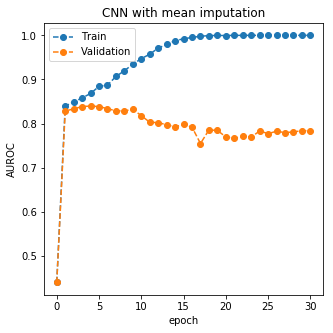

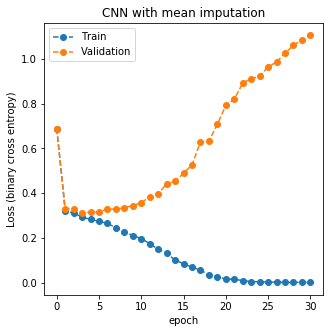

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)
    
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

n_epochs = 30
learning_rate = 1e-3
#(self, in_channels, n_filters, output_size, sequence_len)
model = CNN(35, 64, 1, 48)

model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

outputs = []

print('Epoch', 0)
out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
outputs.append(out)

for epoch in range(0, n_epochs):
    print('Epoch', epoch+1)
    # Train model
    _train_epoch(tr_loader, model, criterion, optimizer)

    # Evaluate model
    out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
    outputs.append(out)

    # Save model parameters
    save_checkpoint(model, epoch+1, 'checkpoint/')

train_losses, val_losses, train_scores, val_scores = zip(*outputs)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
plt.title("CNN with mean imputation")
plt.xlabel('epoch')
plt.ylabel('AUROC')
plt.legend()
plt.savefig('auroc.png', dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
plt.title("CNN with mean imputation")
plt.xlabel('epoch')
plt.ylabel('Loss (binary cross entropy)')
plt.legend()
plt.savefig('loss.png', dpi=300)


In [0]:
 
print(X.shape, y.shape)

X[0,1,:]
  

(12000, 48, 70) (12000,)


array([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,  60.  ,    nan,
          nan,    nan,    nan,  62.  ,  87.  , 137.  ,    nan,    nan,
          nan,    nan,  18.  ,    nan,    nan,  35.35,    nan,    nan,
        30.  ,    nan,    nan,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         1.  ,   0.  ,   1.  ,   1.  ,   1.  ,   1.  ,   0.  ,   0.  ,
         0.  ,   1.  ,   1.  ,   1.  ,   1.  ,   0.  ,   1.  ,   1.  ,
         1.  ,   1.  ,   1.  ,   0.  ,   1.  ,   1.  ])

In [0]:
with open("features_labels_12000.p", 'rb') as f:
      features, df_labels = pickle.load(f)
      X = np.array([df_i.values for df_i in features])[0:10000,:,0:35]
      y = df_labels['In-hospital_death'].values.copy()[0:10000]
      data = b""
      while True:
          packet = s.recv(4096)
          if not packet: break
          data += packet

      data_arr = pickle.loads(data)

UnpicklingError: ignored